<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/3-workshops/2019-04-Technical-University-of-Denmark/14-Precinct-Collaboration-by-location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

## Using GRID and Dimensions together to identify Collaboration within a region

In [1]:
from dimcli.shortcuts import dslquery_json as dslquery
import pandas as pd
import zipfile as zf
import io
import requests
import geopy.distance

ModuleNotFoundError: No module named 'geopy'

## First download the GRID dataset, and extract the addresses.csv file
you can get the GRID dataset from here: https://grid.ac/downloads
Once unzipped, put the types.csv file in your notebook directory...

## you can also download the latest release directly from Figshare...


In [2]:
grid_versions = pd.DataFrame(
    requests.get("https://api.figshare.com/v2/collections/3812929/articles").json()
).sort_values('published_date', ascending=False)

grid_versions.head(2)

,defined_type,doi,group_id,id,published_date,thumb,title,url,url_private_api,url_private_html,url_public_api,url_public_html
0,4,10.6084/m9.figshare.6683654.v1,6072,6683654,2018-06-27T09:50:05Z,,GRID release 2018-06-25,https://api.figshare.com/v2/articles/6683654,https://api.figshare.com/v2/account/articles/6...,https://figshare.com/account/articles/6683654,https://api.figshare.com/v2/articles/6683654,https://figshare.com/articles/GRID_release_201...
1,4,10.6084/m9.figshare.6216392.v1,6072,6216392,2018-05-03T13:02:09Z,,GRID release 2018-05-01,https://api.figshare.com/v2/articles/6216392,https://api.figshare.com/v2/account/articles/6...,https://figshare.com/account/articles/6216392,https://api.figshare.com/v2/articles/6216392,https://figshare.com/articles/GRID_release_201...


In [65]:
grid_download_url = requests.get(grid_versions.loc[1]['url_public_api']).json()['files'][0]['download_url']

with zf.ZipFile(
                io.BytesIO(requests.get(grid_download_url).content)
                ) as thezip:
    
    grid_addresses = pd.read_csv(thezip.open('full_tables/addresses.csv'),low_memory=False)
    grid_institutes = pd.read_csv(thezip.open('full_tables/institutes.csv'),low_memory=False)

In [70]:
grid_details = grid_institutes.merge(grid_addresses, left_on='grid_id', right_on='grid_id', how='outer')

In [129]:
grid_details.head(5)

,grid_id,name,wikipedia_url,email_address,established,line_1,line_2,line_3,lat,lng,postcode,primary,city,state,state_code,country,country_code,geonames_city_id,dist_from_melbourne
0,grid.1001.0,Australian National University,http://en.wikipedia.org/wiki/Australian_Nation...,NaN,1946.0,NaN,NaN,NaN,-35.277800,149.120500,NaN,False,Canberra,Australian Capital Territory,AU-ACT,Australia,AU,2172517.0,465.706096
1,grid.1002.3,Monash University,http://en.wikipedia.org/wiki/Monash_University,NaN,1958.0,NaN,NaN,NaN,-37.908300,145.138000,NaN,False,Melbourne,Victoria,AU-VIC,Australia,AU,2158177.0,19.944366
2,grid.1003.2,University of Queensland,http://en.wikipedia.org/wiki/University_of_Que...,NaN,1909.0,NaN,NaN,NaN,-27.495964,153.009627,NaN,False,Brisbane,Queensland,AU-QLD,Australia,AU,2174003.0,1368.120576
3,grid.1004.5,Macquarie University,http://en.wikipedia.org/wiki/Macquarie_University,NaN,1964.0,NaN,NaN,NaN,-33.775259,151.112915,NaN,False,Sydney,New South Wales,AU-NSW,Australia,AU,2147714.0,712.839058
4,grid.1005.4,UNSW Australia,http://en.wikipedia.org/wiki/University_of_New...,NaN,1949.0,NaN,NaN,NaN,-33.917731,151.230964,NaN,False,Sydney,New South Wales,AU-NSW,Australia,AU,2147714.0,711.126541


## Calculate distance from a point (In this case, the University of Melbourne)

In [45]:
institution = 'grid.1008.9'

In [73]:
def gridcoords(df,grid_id):
    rw = df[df['grid_id'] == grid_id]
    return (rw.iloc[0]['lat'],rw.iloc[0]['lng'])

def getdistance(coord1,coord2):
    try:
        return geopy.distance.distance(coord1,coord2).km
    except:
        return None

source_coords = gridcoords(grid_details,institution)                                                                 

grid_details['dist_from_melbourne'] = grid_details.apply (lambda row: getdistance(source_coords,
                                                                (row['lat'],row['lng'])
                                                             ),axis=1)

## Identify Institutions within a 1 km radius of the University of Melbourne

In [139]:
local_grids =  grid_details[grid_details['dist_from_melbourne'] < 1 ]

In [140]:
grids = list(local_grids.grid_id.unique())
print(len(grids))

29


In [156]:
local_grids.head(2)

,grid_id,name,wikipedia_url,email_address,established,line_1,line_2,line_3,lat,lng,postcode,primary,city,state,state_code,country,country_code,geonames_city_id,dist_from_melbourne
7,grid.1008.9,University of Melbourne,http://en.wikipedia.org/wiki/University_of_Mel...,NaN,1853.0,NaN,NaN,NaN,-37.797115,144.959972,NaN,False,Melbourne,Victoria,AU-VIC,Australia,AU,2158177.0,0.000000
36,grid.1042.7,Walter and Eliza Hall Institute of Medical Res...,https://en.wikipedia.org/wiki/Walter_and_Eliza...,NaN,1915.0,NaN,NaN,NaN,-37.798000,144.956000,NaN,False,Melbourne,Victoria,AU-VIC,Australia,AU,2158177.0,0.363357


## Search for all publications produced by these institutions since 2010

In [143]:
def publicationsfromgrid(grids,limit=1000,pubskip='qpub'):
    searchstring = """
    search publications
       where
         research_orgs.id in [{}]
        and year >= "2010"
        and id < "{}"
    return publications[id+doi+times_cited+year+author_affiliations] sort by id
    limit {}
    """.format(",".join([ '"{}"'.format(g) for g in grids]),pubskip,limit)
    #print (searchstring)
    return searchstring

In [144]:
def dslsearchpublications(grids):
    pubskip = 'q'
    pubs = []
    total_pubs = []
    result = {}
    while (pubskip == 'q') or (len(pubs) == 1000):
        pubs = dslquery(publicationsfromgrid(grids,pubskip=pubskip)).get('publications',[])
        total_pubs += pubs
        pubskip = pubs[len(pubs)-1]['id']  
            
                            
    return total_pubs

In [145]:
def publicationsfromgridlist(grids):
    pubs=[]
    
    idchunks = [grids[x:x + 499] for x in range(0, len(grids), 499)]
    for ids in idchunks:
        pubs += dslsearchpublications(ids)
        print(len(pubs))
        
    return pubs

In [ ]:
industry_pubs = publicationsfromgridlist(grids)

In [147]:
len(industry_pubs)

70215

## Citations by year of publication for the region

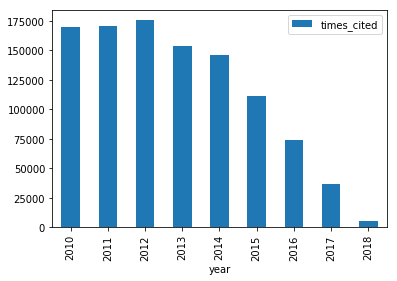

In [148]:
pd.DataFrame(industry_pubs).groupby(['year']).sum().plot(kind='bar')

## Publications by year for the region

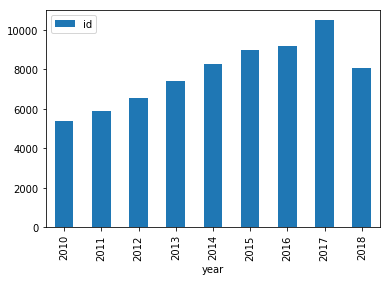

In [149]:
pd.DataFrame(industry_pubs)[['id','year']]. \
    groupby(['year']). \
    count(). \
    plot(kind='bar')

## Filter Publications list for publications produced by two or more institutions in the region

In [150]:
industry_aff = [dict( 
       year = p['year'],
       pubid = p['id'],
       grid = aff['id'],
       inst = aff['name']
    
     )
    for p in industry_pubs
    for auth in p.get('author_affiliations', [{}])[0]
    for aff in auth.get('affiliations',[])
       if aff.get('id','') in grids
      
]

In [151]:
idf = pd.DataFrame(industry_aff).drop_duplicates()

In [152]:
idf[['inst','grid','pubid']]. \
    groupby(['inst','grid']). \
    count(). \
    reset_index(). \
    sort_values(by='pubid', ascending=False)

,inst,grid,pubid
16,University of Melbourne,grid.1008.9,62186
13,Royal Children's Hospital,grid.416107.5,4356
14,Royal Melbourne Hospital,grid.416153.4,4193
20,Walter and Eliza Hall Institute of Medical Res...,grid.1042.7,2695
7,Florey Institute of Neuroscience and Mental He...,grid.418025.a,1682
15,Royal Women's Hospital,grid.416259.d,1243
10,Melbourne Health,grid.429299.d,496
17,Victorian Infectious Diseases Reference Labora...,grid.433799.3,479
11,Melbourne Sexual Health Centre,grid.490309.7,251
8,IBM Research - Australia,grid.481553.e,163


In [153]:
ia = pd.DataFrame(industry_aff)

def precinct_collab(series):
    precinct = [grid
             for grid in series.tolist()
             if grid in grids ]
    if len(set(precinct)) > 1:
        return 1
    else:
        return 0
    return 

iadf =ia.groupby(['pubid','year']). \
     agg({'grid': [precinct_collab],
          
         }).reset_index()

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


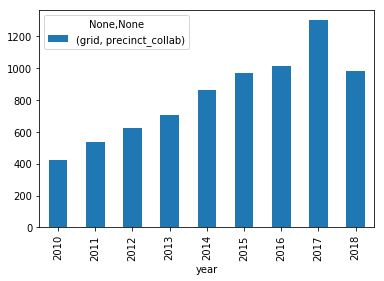

In [157]:
iadf.groupby('year').sum().plot(kind='bar')

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 